In [244]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math

#### Demo
Raw data form

In [169]:
classname_list = os.listdir(os.path.join("xlsx"))
classfile_path = os.path.join("xlsx",classname_list[0])
class_coor = pd.read_excel(classfile_path)
class_coor.iloc[:5] 
#class_coor = class_coor[['X','Y', 'ID']]

,X,Y,Angle,FN,OriginalFN,Time,ID
0,243.781903,284.188413,0.000000,1,1,0.000000,1
1,243.551224,286.511094,1.669788,2,2,0.033333,1
2,242.954114,291.045441,1.701729,3,3,0.066667,1
3,241.835700,296.159237,1.786111,4,4,0.100000,1
4,240.165826,302.054824,1.846808,5,5,0.133333,1


#### Convert coordinates from xlsx files into npy files

In [168]:
classname_list = os.listdir(os.path.join("xlsx"))
for xlsx in classname_list:
    classfile_path = os.path.join("xlsx",xlsx)
    class_coor = pd.read_excel(classfile_path)
    #n_sample = class_coor.ID.unique()
    ID_col_idx = class_coor.columns.get_loc("ID") #6
    class_coor = class_coor.values #
    ID_before=1
    each_sample=[];all_sample=[]
    for i in range(class_coor.shape[0]):
        if class_coor[i][ID_col_idx]==ID_before:
            each_sample.append(class_coor[i])
        else:
            all_sample.append(np.array(each_sample))
            ID_before=class_coor[i][ID_col_idx]
            each_sample = []
            each_sample.append(class_coor[i])
    all_sample.append(np.array(each_sample))
    all_sample = np.array(all_sample)
    file_name = "class"+str(classname_list.index(xlsx))+"_"+xlsx[6:-5]+'_'+str(all_sample.shape[0])+'.npy'
    file_path = os.path.join("npy", "coor", "fullsteps_fullcolumns", file_name)
    print(file_path, "is saved")
    np.save(file_path, all_sample)

npy\coor\fullsteps_fullcolumns\class0_A1_844.npy is saved
npy\coor\fullsteps_fullcolumns\class1_A4_1029.npy is saved
npy\coor\fullsteps_fullcolumns\class2_Sp7_1317.npy is saved
npy\coor\fullsteps_fullcolumns\class3_Y1_1098.npy is saved
npy\coor\fullsteps_fullcolumns\class4_Y4_1029.npy is saved


#### Format data
* Discard samples shorter than `step_limit = 60`
* Truncate samples into `step_limit = 60`
* Only keep three columns: x coor, y coor, angle

Take a look at the distribution of trajectory lengths

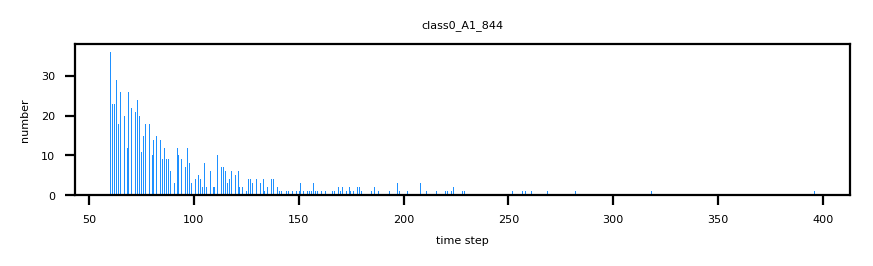

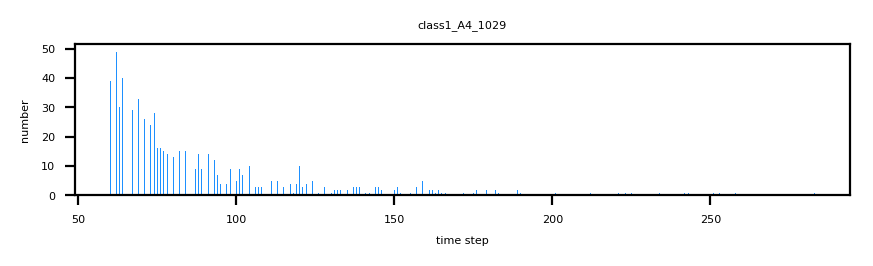

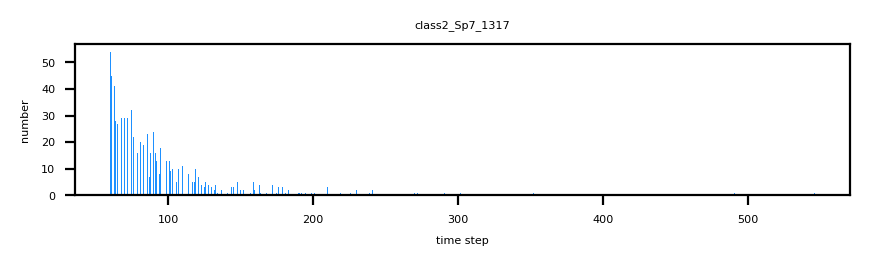

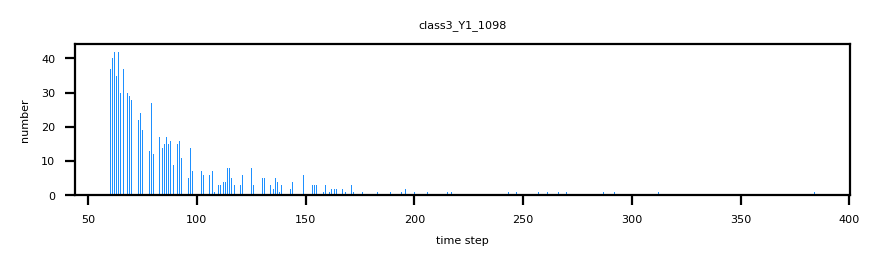

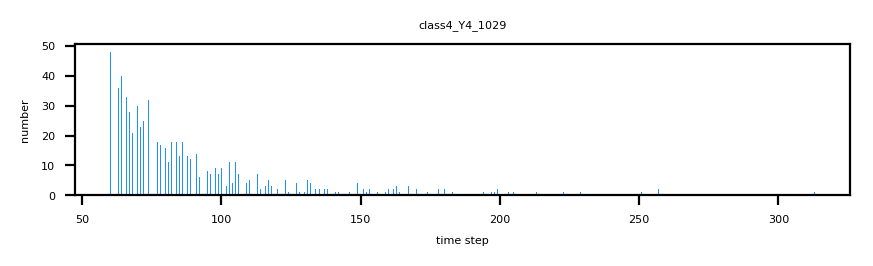

In [190]:
classname_list = os.listdir(os.path.join("npy", "coor", "fullsteps_fullcolumns"))
step_limit = 60
for file_fl in classname_list:
    class_fl = np.load(os.path.join("npy", "coor", "fullsteps_fullcolumns", file_fl))
    class_steps = []
    for sample in class_fl:
        class_steps.append(sample.shape[0])
        if sample.shape[0]<60:
            print(sample.shape[0])
    #with plt.xkcd():     
    plt.figure(figsize=(5, 1), dpi=200)
    plt.hist(class_steps, bins=class_fl.shape[0], histtype='bar', color='dodgerblue')
    plt.title(file_fl[:-4], fontsize=4)
    plt.xlabel("time step", fontsize=4)
    plt.ylabel("number", fontsize=4)
    plt.tick_params(labelsize=4)
    plt.show()

Seems all lenghts larger than 60. To keep as many samples as possible, we set `step_limit = 60`

In [341]:
classname_list = os.listdir(os.path.join("npy", "coor", "fullsteps_fullcolumns"))
step_limit = 60
for file_fl in classname_list:
    class_fl = np.load(os.path.join("npy", "coor", "fullsteps_fullcolumns", file_fl))
    #print(file_fl)
    class_trunc=[]
    for i in range(class_fl.shape[0]):
        if class_fl[i].shape[0]>=step_limit:
            sample_trunc=class_fl[i][:60]
            class_trunc.append(sample_trunc)
    class_trunc = np.array(class_trunc)
    class_trunc = class_trunc[:, :, :3]
    #print("after, sample shape:", class_trunc.shape)
    file_name = file_fl[:9] +"_"+str(class_trunc.shape[0])+'_trunc60.npy'
    file_path = os.path.join("npy", "coor", "60steps_3xyang", file_name)
    print(file_path, "is saved")
    np.save(file_path, class_trunc)

npy\coor\60steps_3xyang\class0_A1_844_trunc60.npy is saved
npy\coor\60steps_3xyang\class1_A4_1029_trunc60.npy is saved
npy\coor\60steps_3xyang\class2_S7_1317_trunc60.npy is saved
npy\coor\60steps_3xyang\class3_Y1_1098_trunc60.npy is saved
npy\coor\60steps_3xyang\class4_Y4_1029_trunc60.npy is saved


#### Sequential features extraction

Change 3 sequences(velocity, angle, angular velocity) from 2 sequences(x, y coordinates).

Calculation of velocity involves coordinates of 2 points, here this velocity is assigned to the second point in the original trajectory sequence. Similarly, calculation of angular velocity (av or delta theta) also involves angles of 2 points, but the calculation of each angle involves 2 points. In total, this angular velocity calculation involves coordinates of 3 points. This angular velocity is assigned to the middle point.

Note: for n points, we can only get (n-1) velocities, (n-1) angles and (n-2) angular velocities. This is illustrated in the picture below. But to make my life easier, I will just keep both the v and av sequence as (n-2) by giving up the velocity of last point. [0, 0] is added to the begining and ending of v and av sequences to line up with the coor sequence. Therefore, the final sequences of v and av are still same length as coor.
<img src="http://i65.tinypic.com/1625fo8.png" alt="drawing" width="600"/>

In this example, it starts with coordinate sequence of 5 points, ends with a velocity sequence of 3 points and an angular velocity sequence of 3 points.

This notation is important when we visualize the event labels on the trajectory. 

In [327]:
def ThreePointsAngle(p1, p2, p3):
    vec1 = [p2[0]-p1[0], p2[1]-p1[1]]
    vec2 = [p3[0]-p2[0], p3[1]-p2[1]]
    ang1 = math.atan2(vec1[1], vec1[0]) # math.atan2(y,x) returns angle from -pi to pi
    ang2 = math.atan2(vec2[1], vec2[0])
    angTurning = ang2-ang1
    if angTurning>math.pi:
        angTurning = 2*math.pi-angTurning
    elif angTurning<-math.pi:
        angTurning = 2*math.pi+angTurning
    return ang1, ang2, angTurning

def TwoPointsDistance(p1, p2):
    xdiff = p2[0] - p1[0]
    ydiff = p2[1] - p1[1]
    return math.sqrt(math.pow(xdiff,2) + math.pow(ydiff,2))

#### Demo

Turning angle is confined between -π and π. With the setup of `math.atan2()`, clock-wise turning is negative, anticlock-wise turning is positive. Also turning angle smaller than -π or larger than π is modified to range (-π,π) by plus π or minus π.

In [328]:
p1=[1,0.3]
p2=[2,1]
p3=[4,1.5]
angTurning = ThreePointsAngle(p1, p2, p3)
print("angTurning:", angTurning)

angTurning: (0.6107259643892086, 0.24497866312686414, -0.36574730126234445)


<img src="http://i67.tinypic.com/104iuwx.png" alt="drawing" width="600"/>

In [329]:
p1=[0,0]
p2=[-2,0.5]
p3=[-4,-0.5]
angTurning = ThreePointsAngle(p1, p2, p3)
print("angTurning:", angTurning)

angTurning: (2.896613990462929, -2.677945044588987, 0.7086262721276704)


<img src="http://i66.tinypic.com/105e8v5.png" alt="drawing" width="600"/>

#### Note:
    This step generates array with 6 columns:
    first 3 columns are from the old coordinates file: x, y, angles(old).
    last 3 columns are angles(new), velocity, angular velocity.

In [361]:
classname_list = os.listdir(os.path.join("npy", "coor", "60steps_3xyang"))
for classfile in classname_list:
    print(classfile, "-----------")
    classfile_path = os.path.join("npy", "coor", "60steps_3xyang", classfile)
    class_coor = np.load(classfile_path)
    print("coor seq shape:", class_coor.shape)
    
    class_vav = [] 
    for sample_coor in class_coor:
        sample_vav = []
        for n in range(1, sample_coor.shape[0]-1):
            p1 = list([sample_coor[n-1][0],sample_coor[n-1][1]])
            p2 = list([sample_coor[n][0],sample_coor[n][1]])
            p3 = list([sample_coor[n+1][0],sample_coor[n+1][1]])
            x = sample_coor.item((n,0));y = sample_coor.item((n,1));ang = sample_coor.item((n,2))
            ang1, ang2, angTurning = ThreePointsAngle(p1, p2, p3)
            sample_vav.append(np.array([x,y,ang,ang2,TwoPointsDistance(p1, p2), angTurning]))
        sample_vav = np.array(sample_vav)
        av_first = sample_vav[0]; av_last = sample_vav[-1]
        av_first = np.reshape(av_first,(1,av_first.shape[0]))
        av_last = np.reshape(av_last,(1,av_last.shape[0]))
 
        sample_vav = np.append(av_first, sample_vav, axis=0)
        sample_vav = np.append(sample_vav, av_last, axis=0)
        class_vav.append(sample_vav)
    class_vav = np.array(class_vav)
    print(" vav seq shape:", class_vav.shape)
    file_name = classfile[:-11] +'angvav.npy'
    file_path = os.path.join("npy", "3xyang3angvav",file_name)
    print(file_path, "is saved")
    np.save(file_path, class_vav)
    

class0_A1_844_trunc60.npy -----------
coor seq shape: (844, 60, 3)
 vav seq shape: (844, 60, 6)
npy\3xyang3angvav\class0_A1_844_angvav.npy is saved
class1_A4_1029_trunc60.npy -----------
coor seq shape: (1029, 60, 3)
 vav seq shape: (1029, 60, 6)
npy\3xyang3angvav\class1_A4_1029_angvav.npy is saved
class2_S7_1317_trunc60.npy -----------
coor seq shape: (1317, 60, 3)
 vav seq shape: (1317, 60, 6)
npy\3xyang3angvav\class2_S7_1317_angvav.npy is saved
class3_Y1_1098_trunc60.npy -----------
coor seq shape: (1098, 60, 3)
 vav seq shape: (1098, 60, 6)
npy\3xyang3angvav\class3_Y1_1098_angvav.npy is saved
class4_Y4_1029_trunc60.npy -----------
coor seq shape: (1029, 60, 3)
 vav seq shape: (1029, 60, 6)
npy\3xyang3angvav\class4_Y4_1029_angvav.npy is saved
